HW2 testing bench  

In [1]:
# %% FUNCTIONS
import timeit
from tqdm import tqdm
import numpy as np
import heapq as h
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import pdb
import math
import math as m
from icecream import ic
import pandas as pd
import random
import time
import threading

Bronze_data Range 	= -15.249988 	<->	 27.0
Silver_data Range 	= 0.0 		<->	 6.868231
Gold_data Range 	= -0.409776 	<->	 0.41609
Platinum_data Range 	= -6.24986 	<->	 2.797242


Text(0.5, 1.0, 'Data approximation sandbox')

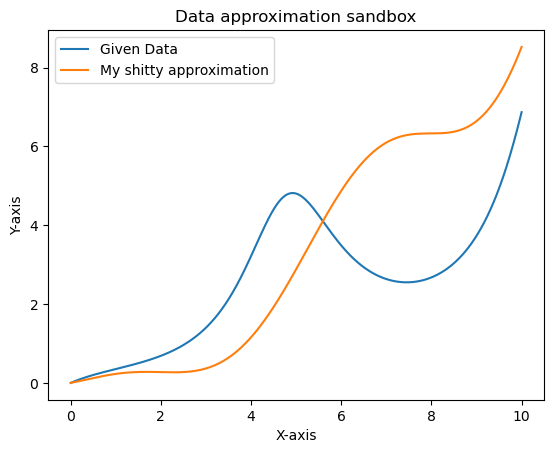

In [2]:
# LOAD DATA:
Bronze_data = np.loadtxt("Bronze.txt", dtype=float, delimiter=',')
Silver_data = np.loadtxt("Silver.txt", dtype=float, delimiter=',')
Gold_data = np.loadtxt("Gold.txt", dtype=float, delimiter=',')
Platinum_data = np.loadtxt("Platinum.txt", dtype=float, delimiter=',')

print('Bronze_data Range \t=', np.min(
    Bronze_data[:, 1]), '\t<->\t', np.max(Bronze_data[:, 1]))
print('Silver_data Range \t=', np.min(
    Silver_data[:, 1]), '\t\t<->\t', np.max(Silver_data[:, 1]))
print('Gold_data Range \t=', np.min(
    Gold_data[:, 1]), '\t<->\t', np.max(Gold_data[:, 1]))
print('Platinum_data Range \t=', np.min(
    Platinum_data[:, 1]), '\t<->\t', np.max(Platinum_data[:, 1]))

Y_range_Cu = (np.min(Bronze_data[:, 1]), np.max(Bronze_data[:, 1]))
Y_range_Ag = (np.min(Silver_data[:, 1]), np.max(Silver_data[:, 1]))
Y_range_Au = (np.min(Gold_data[:, 1]), np.max(Gold_data[:, 1]))
Y_range_Pt = (np.min(Platinum_data[:, 1]), np.max(Platinum_data[:, 1]))

data = Silver_data
plt.plot(data[:,0],data[:,1],label='Given Data')
x = np.linspace(0,10,1000)
y = .1* np.power(x+.1,2)+ .2*(x)*np.cos(x)
plt.plot(x,y,label='My shitty approximation')
plt.legend()
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Data approximation sandbox')

In [3]:
class Function_node(object):
    # Global parameters tha bound acceptable operators
    # last is the header indicator (indexing from 1!)
    node_types = ('+', '-', '*', '/', '^', 'sin', 'cos',
                  'const', 'X', 'ERR')
    dual_operators = ('+', '-', '*', '/', '^')
    single_operators = ('sin', 'cos')

    # Constructor for a function node
    def __init__(self, function_name, value=None):
        self.num_childs = 0
        self.value = value
        # assigning a name in our accepted list
        try:
            if function_name not in self.node_types:
                raise ValueError(
                    F"Invalid input: {function_name}. Please enter a valid node type \n\n\t run> heap.node_types for the list")
            else:
                self.function_name = function_name
        except ValueError as err_msg:
            # print(err_msg)
            self.function_name = 'ERROR'
            sys.exit()  # exit if there is an issue

        # set number of children gien type

        if self.function_name in self.dual_operators:
            self.req_num_childs = 2
        elif self.function_name in self.single_operators:
            self.req_num_childs = 1
        else:
            self.req_num_childs = 0

    # Node methods to integrate into our tree:
    def add_child_count(self):
        self.num_childs += 1

    def can_add_child(self):
        return self.num_childs < self.req_num_childs

    def copy_node(self):
        # returns a copy of the node
        new_node = Function_node(function_name=self.function_name,
                                 value=self.value)
        new_node.num_childs = self.num_childs
        return new_node

    # printing a node:
    def __str__(self):  # print statement
        if self.function_name == 'const':
            return f"{round(self.value,2)}"
        elif self.function_name == 'X':
            return "X"
        else:
            return f"{self.function_name}"

In [4]:
class NP_Heap(Function_node):
    def __init__(self, length=2, Heap=None, Randomize=False, max_depth=4, const_prob=.45, C_range=(-10, 10)):
        self.heap = np.full(length, None, dtype=object)
        # ALL Operators ('+', '-', '*', '/', '^', 'sin', 'cos')
        self.operators = ('*', '+', '-', '/', 'sin', 'cos')
        self.trig_operators = ('sin', 'cos')
        self.non_operator = ('X', 'const')

        if Randomize:
            self.Random_Heap(max_depth=max_depth,
                             const_prob=const_prob,
                             C_range=C_range)

 ############# Heap Manipulation #############

    # INDEXING AT 1:

    def get_parent_idx(self, child_idx):
        return int(child_idx/2)

    def get_parent(self, child_idx):
        parent_idx = self.get_parent_idx(child_idx)
        return self.heap[parent_idx]

    def get_left_child_idx(self, parent_idx):
        return 2 * parent_idx

    def get_right_child_idx(self, parent_idx):
        return 2 * parent_idx + 1

    def get_left_child(self, parent_idx):
        left_child = self.heap[self.get_left_child_idx(parent_idx)]
        return left_child

    def get_right_child(self, parent_idx):
        right_child = self.heap[self.get_right_child_idx(parent_idx)]
        return right_child

    def get_children_idx(self, parent_idx):
        return 2*parent_idx, 2*parent_idx+1

    def get_children(self, parent_idx):
        return self.heap[2*parent_idx], self.heap[2*parent_idx+1]

    def get_children_type(self, parent_idx):
        L, R = self.get_children(parent_idx)
        return type(L), type(R)

    def depth(self):
        deepest_node_ind = max(np.arange(self.heap.size)[self.heap != None])
        return int(m.floor(m.log2(deepest_node_ind)))

    def has_root(self):
        if self.heap[0] == None:
            return False
        else:
            return True

    def copy(self, given_len=None):  # TODO Test
        # ERROR HERE! WE had to not just initialize a new heap but also the nodes themselves... duh....
        length = given_len if given_len else self.heap.size
        h = NP_Heap(length=length)

        for i, node in enumerate(self.heap):
            if node == None:
                h.heap[i] = None
            else:
                h.heap[i] = node.copy_node()
        return h

 # INSERT FUNCTION
    def insert(self, parent_indx, node_obj, position=None):
        # check for size availibility or resize

        # check heap length if short, doubles array until acceptable
        while self.heap.size - 1 < self.get_right_child_idx(parent_indx):
            #print('doubled',self.heap.size ,self.get_right_child_idx(parent_indx)  )
            self.heap = np.append(self.heap,
                                  np.full(self.heap.size, None).astype(Function_node))

        L_indx, R_indx = self.get_children_idx(parent_indx)

        # if a position is provided it will insert WITH REPLACEMENT
        if position:
            if position == 'L':
                self.heap[L_indx] = node_obj
            elif position == 'R':
                self.heap[R_indx] = node_obj
            else:
                print("invalid arg position = 'L' or 'R'")

        # if no position provided it will insert left to right if a child is empty
        elif not self.heap[L_indx]:
            self.heap[L_indx] = node_obj
        elif not self.heap[R_indx]:
            self.heap[R_indx] = node_obj

        else:  # insert to the left child. #TODO: implement recursive insert.
            print('ERROR: Parent children filled')
            #self.insert(self,parent_indx = L, value = value )
        return None

 # ---------------------------------------------

 ####### DISPLAY FUNCTIONS ##########
    def __str__(self):
        return self.print_heap_tree()

    def print_heap_tree(self, index=1, prefix="", is_left=True):  # CALLED BY __str__ method
        output = ""
        if index < len(self.heap) and self.heap[index] is not None:
            # Process right child first (going down)
            output += self.print_heap_tree(index=2*index+1, prefix=prefix + (
                "|   " if is_left else "    "), is_left=False)
            # Add the current node to the output
            output += prefix + "|-- " + str(self.heap[index]) + "\n"
            # Process left child
            output += self.print_heap_tree(index=2*index, prefix=prefix + (
                "|   " if not is_left else "    "), is_left=True)
        # else:
            # Indicate the absence of a node with [...]
            # output += prefix + "|-- [...]\n"
        return output

    def print_arr(self):  # shows the heap and indexes
        heap_str = [str(node) for node in self.heap]
        ind_arr = np.arange(self.heap.size)
        max_def = max(ind_arr[self.heap != None])+1
        print(np.stack((ind_arr[1:max_def], heap_str[1:max_def])))
        return None

    def plot_approximation(self, X_range=(0, 10), target_data=None, y_pred=None,
                           data_name='Data'):
        X_arr = np.linspace(X_range[0], X_range[1], 1000)

        if type(target_data) != None:
            plt.plot(target_data[:, 0], target_data[:, 1], label='Given_data')

        if not y_pred:
            y_pred = [self.evaluate(X=x) for x in X_arr]

        plt.plot(X_arr, y_pred, label='GA Solution')
        plt.legend()
        plt.xlabel('X-axis')
        plt.ylabel('Y-axis')
        plt.title(data_name + ' approximation ')
        plt.show()
        return None

    def build_function(self, index=1):
        # CGPT Func
        heap_array = self.heap
        # Base case: if the index is out of bounds or the node is None, return an empty string
        if index >= len(heap_array) or heap_array[index] is None:
            return ""

        # Get the current node's value
        current_node = str(heap_array[index])

        # Define operators with higher precedence
        higher_precedence = ['*', '/', 'sin', 'cos']

        # Get the left and right child indices
        left_child_index = 2 * index
        right_child_index = 2 * index + 1

        # Recursively build the left and right subtrees
        left_subtree = self.build_function(index=left_child_index)
        right_subtree = self.build_function(index=right_child_index)

        # Check if parentheses are needed around children
        if left_subtree and current_node in higher_precedence:
            left_subtree = f"({left_subtree})"
        if right_subtree and current_node in higher_precedence:
            right_subtree = f"({right_subtree})"

        # Combine the current node, left subtree, and right subtree to form the expression
        expression = f"{left_subtree}{current_node}{right_subtree}" if left_subtree or right_subtree else current_node

        return expression
 # ---------------------------------------------

 ####### Main functionalities ###########
    def Random_Heap(self, Index=1, max_depth=4, const_prob=.4, C_range=(-10, 10)):
        '''
        this is a function that will be called recursively to build valid trees to every index
            - Start at a given index (default is root = 1) initialized as an operator
                - If not initialized it assigns a random operator. 
            - given operator type, select the number of required children (can = req chlds > chlds)
            for each:
                - Check for termination criteria that make the children of that node constants
                    --> either some random probability or a maximum depth is reached
                - if not terminated, select a random operator
                insert that node left to right into the parent children 
                - note that the node was added so the can add child is accurate. 

        '''
        # initialize root.
        if self.heap[Index] == None:
            self.heap[Index] = Function_node(np.random.choice(self.operators))
        while self.heap[Index].can_add_child():  # TODO TEST

            # SORRY FOR THE TRIPPLE NESTING :(

            # criteria for a constant child
            if self.depth() >= max_depth - 1 or np.random.rand() < const_prob:  # no operators terminate with constants

                if self.heap[Index].function_name in self.trig_operators:
                    node_name = 'X'
                    node_val = None
                # check left child has been populated to ensure they are not both same (irrelevant node)
                elif self.heap[Index].num_childs == 1:
                    L_name = self.heap[2 * Index].function_name
                    # if this is the second constant make it opposit
                    if L_name in ['X', 'const']:
                        node_name = 'const' if L_name == 'X' else 'X'
                        node_val = np.random.uniform(C_range[0], C_range[1]
                                                     ) if node_name == 'const' else None
                    else:  # otherwise random
                        node_name = np.random.choice(['X', 'const'])
                        node_val = np.random.uniform(C_range[0], C_range[1]
                                                     ) if node_name == 'const' else None

                # selcting first child:.
                else:
                    node_name = np.random.choice(['X', 'const'])
                    node_val = np.random.uniform(
                        C_range[0], C_range[1]) if node_name == 'const' else None

            # operator child:
            else:
                node_name = np.random.choice(self.operators)
                node_val = None

            new_node = Function_node(function_name=node_name, value=node_val)
            self.insert(parent_indx=Index, node_obj=new_node)
            # note the addition of a child to break while loop
            self.heap[Index].add_child_count()
        # TODO maybe immediately prune/consolidate shity nodes

        L_child, R_child = self.get_children(Index)
        # self.print_arr()
        if L_child.function_name in self.operators:
            self.Random_Heap(Index=2*Index, max_depth=max_depth,
                             const_prob=const_prob, C_range=C_range)
        if type(R_child) == Function_node and R_child.function_name in self.operators:
            self.Random_Heap(2*Index+1, max_depth=max_depth,
                             const_prob=const_prob, C_range=C_range)

    # ****  EVALUATE A NODE ***:
    def evaluate(self, node_ind=1, X=1):  # tree root = 1
        # evaluates a node given its index

        def node_operation(operator, operand):
            if operator == '+':
                return operand[0]+operand[1]
            elif operator == '-':
                return operand[0] - operand[1]
            elif operator == '*':
                return operand[0] * operand[1]
            elif operator == '/':
                if operand[1] == 0:
                    return 1.0e6
                return operand[0] / operand[1]
            elif operator == '^':
                return operand[0] ** operand[1]
            elif operator == 'sin':
                return np.sin(operand)
            elif operator == 'cos':
                return np.cos(operand)

        # MAIN LOOP:

        L_child, R_child = self.get_children(node_ind)
        L_indx, R_indx = self.get_children_idx(node_ind)
        children_types = self.get_children_type(node_ind)

        # CHECKS left child, if an operator, evaluate recursively returning a constant. If X, assign it.

        # checks for None leaf
        if type(L_child) is None:
            pass

        elif L_child.function_name in self.operators:
            L_child.value = self.evaluate(node_ind=2*node_ind, X=X)

        elif L_child.function_name == 'X':
            L_child.value = X
        if R_child == None:
            pass
        elif R_child.function_name in self.operators:
            R_child.value = self.evaluate(node_ind=2*node_ind+1, X=X)

        elif R_child.function_name == 'X':
            R_child.value = X

        # terminating state: both children are constandts (floats) or Nan (with at least a constant) after being evaluated
        node_operator = self.heap[node_ind].function_name
        try:
            if Function_node not in children_types:
                raise TypeError(
                    f"Invalid children type for operator: {node_operator} \n\t L/R children are: {(L_child, R_child)}")

            # i.e its sin, cos, tan etc (as defined above
            elif node_operator in self.trig_operators:

                if None not in (L_child, R_child):
                    raise ValueError(
                        f"Invalid children type for operator: {node_operator} \n\t L/R children are: {(L_child, R_child)}")
                elif type(L_child):  # if None use the right child value
                    node_val = node_operation(node_operator, L_child.value)
                elif R_child:
                    node_val = node_operation(node_operator, R_child.value)
            else:
                node_val = node_operation(
                    node_operator, (L_child.value, R_child.value))

        except ValueError as err_msg:
            sys.exit()

        # DIAGNOSTIC
        '''
        msg_out = (
            f"at the root evaluating with:\n\t - parent node index {node_ind}"
            f"\n\t - operator {node_operator}"
            f"\n\t - with children {[str(x) for x in self.heap[[L_indx, R_indx]]]}"
            f"\n result passed {node_val}"
        )
        #print(msg_out)
        '''
        return node_val
    # **** END NODE EVAL   ***

    def MSE(self, point_cloud, plotting=False):
        # RECALL: MSE = (1/n) * Σ(actual – forecast) ^2
        # TODO subsection (skip every other point)
        X_arr = point_cloud[:, 0]
        y = point_cloud[:, 1]
        y_pred = np.array([self.evaluate(X=x) for x in X_arr])
        MSE = np.sum(np.square(y_pred-y)/y.shape[0])

        if plotting:
            self.plot_approximation(X_arr, y_pred, y_true=y)
        return MSE

    def fitness(self, target_data, T=.05):
        MSE = self.MSE(target_data)
        return np.exp(-T*MSE) + 1e-6, MSE

 # #### EP Functions ########## :
    '''
        IDEAS: 
            - Most vanilla: search through heap for the constants and +_ by X small % of the value
            - Adding operations: for chain terminating variables, replace them with the + operator 
                                 and add a small constant to the variable
            - Mutation schedules: annealing or adaptive mutation (increases if stagnating decreases if progress)
            - Optimization by consolidating into one function so we dont have to traverse heap. (in practice heap should be small!)
    '''

    # TODO newar zero increase mutation size
    def Constant_Mutation(self, change_prcnt=.02, min_mutation=.05):
        # small change to constants and addition/substraction to variables
        # basic: for node in heap, if name = const +_ X%
        for node in self.heap:
            if type(node) == Function_node and node.function_name == 'const':
                R = abs(change_prcnt*node.value)
                # makes sure the change is at least a min for near zero constant
                Range = max(R, min_mutation)
                node.value += random.uniform(-1*Range, Range)
        return self

    def Operator_Mutation(self, swap_num=1):
        for i, node in enumerate(self.heap):
            if type(node) == Function_node:  # only operate over nodes....
                if node.function_name == '*':
                    # self.print_arr()
                    node.function_name = '/'
                    # self.print_arr()
        return None

    ##### BLOAT PROBLEM ####
    # TODO  self.depth() and getting nodes at a maximum depth
    def depth_consolidation(self, max_depth=5):
        if self.depth() > max_depth:
            for node in self.heap[max_depth]:
                # calculate averave value and consolidate the node to this value. conditional for large stdv?
                print('Need to implement')
        return None

    def pruning(self):  # TODO
        # deletes useless tree (tree that evaluates to 1 for a mult child or a 0 for a + child/sin cos delete)
        return None

    def hoist_mutation(self):  # TODO
        # Chooses a tree that evaluates to the same constant through x-range and replaces it by the constant
        return None

    # TODO
    def Random_subtree(self):
        # adds random subtree to some function
        pass

    def NUCLEAR_DIVERSIY(self):
        #
        pass

    def subtree(self, indx):
        subtree_ind = [indx]
        subtree_depth = self.depth() - int(m.floor(m.log2(indx)))  # heap depth - node depth
        for i in range(1, subtree_depth+1):
            for j in range(indx*2**i, (indx+1)*2**i):
                subtree_ind.append(j)

        return subtree_ind, self.heap[subtree_ind]

In [5]:
def Random_Search(evaluations, data, max_depth=3, const_prob=.5, C_range=(-10, 10)):
    MSE_log = []
    best_solution = None

    best_function_err = 1e9

    for i in tqdm(range(evaluations), desc='Random Search:', leave=False):
        function = NP_Heap(Randomize=True, max_depth=max_depth,
                           const_prob=const_prob,
                           C_range=C_range)
        MSE_i = function.MSE(data)
        if MSE_i < best_function_err:
            best_solution = function
            best_function_err = MSE_i
            MSE_log.append([i, MSE_i])

    return best_solution, np.array(MSE_log)

In [11]:
start = time.time()
function, mse_arr = Random_Search(2000,
                                  data=Bronze_data,
                                  max_depth=3,
                                  C_range=Y_range_Cu)
runtime = time.time() - start


Random Search::   0%|          | 7/2000 [00:00<00:31, 62.73it/s]

28.653712034225464
|       |-- X
|   |-- +
|   |   |-- -6.58
|-- *
    |-- X



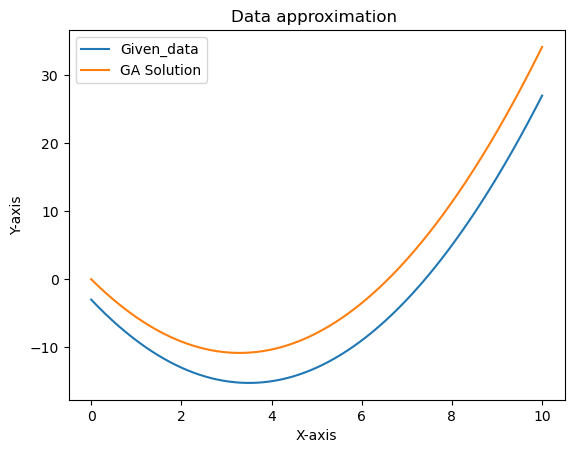

In [12]:
print(runtime)
print(function)

function.plot_approximation(target_data=Bronze_data)

In [8]:
def HC(target_data, step_search_size=128, max_depth=3, mutate_prcnt_change=.01,
       const_prob=.5, C_range=(-10, 10), given_function=None, Optimized_random=0):
    '''
    This function will search random children and move in the best direction from an optimized random start. 

    '''
    if not given_function:
        # initialize return functions
        if Optimized_random:  # does a quick random search to eliminate the trash
            # TODO diversity issue this should be deliberately implemented at the random function level
            Best_Function, _ = Random_Search(evaluations=Optimized_random,
                                             data=target_data,
                                             max_depth=max_depth,
                                             C_range=C_range)
        else:
            Best_Function = NP_Heap(length=32)
            Best_Function.Random_Heap(max_depth=max_depth,
                                      const_prob=const_prob,
                                      C_range=C_range)
    else:
        Best_Function = given_function

    Min_MSE = Best_Function.MSE(target_data)
    MSE_log = []
    Improved = True
    step_num = 0
    while Improved:
        Improved = False  # to be flagged true if any of the children is better than the parent
        # parent of all children to search steps based on the curent best
        gen_parent = Best_Function.copy()
        for _ in range(step_search_size):
            # loops N times testing nearby points
            step = gen_parent.copy()
            step.Constant_Mutation(change_prcnt=mutate_prcnt_change)
            step_MSE = step.MSE(target_data)
            if step_MSE < Min_MSE:
                # this will track best step at a position.
                Best_Function = step
                Min_MSE = step_MSE
                Improved = True  # only needs to happen once to be overritedn
        step_num += 1
        MSE_log.append([step_num*step_search_size, Min_MSE])

        #print('loop ', step_num, ' DONE')
        #print('Best child \n',Best_Function)
        #print('min MSE', Min_MSE)

    return Best_Function, MSE_log
# Random starts


def RSHC(Starts, target_data, step_search_size=128, max_depth=3, mutate_prcnt_change=.02,
         const_prob=.5, C_range=(-10, 10), Optimized_random=0):

    improvement_log = []
    total_evals = 0
    Best_MSE = 1e7
    best_function = None
    for i in tqdm(range(Starts), desc='RSHC:'):
        function, mse_arr = HC(step_search_size=step_search_size,
                               target_data=target_data,
                               mutate_prcnt_change=mutate_prcnt_change,
                               max_depth=max_depth,
                               const_prob=const_prob,
                               C_range=C_range,
                               Optimized_random=Optimized_random)
        evals, best_MSE_i = mse_arr[-1]
        total_evals += evals
        if best_MSE_i < Best_MSE:
            improvement_log.append([total_evals, best_MSE_i])
            best_function = function
            Best_MSE = best_MSE_i
    return best_function, improvement_log

RSHC:: 100%|██████████| 10/10 [00:50<00:00,  5.09s/it]


|   |-- X
|-- *
    |   |-- 0.93
    |-- /
        |   |-- 7.43
        |-- -
            |-- X
 
 MSE=  1.0929373466098642


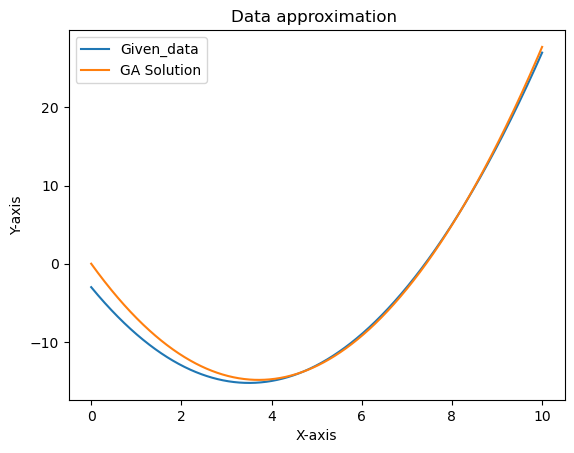

In [13]:
#%% RUN RSHC 
best_function, performance_log= RSHC(Starts= 10,
                                    step_search_size=25,
                                    mutate_prcnt_change=.08,
                                    target_data=Bronze_data,
                                    max_depth=3,
                                    C_range=Y_range_Cu,
                                    Optimized_random = 100)
print(best_function, '\n MSE= ',best_function.MSE(Bronze_data))
best_function.plot_approximation(target_data=Bronze_data)

EVOLUTIONARY PROGRAMMING:

In [14]:
# %%############################################################
## **** EVOLUTIONARY ALGOS ***** ##
# TODO test turnament selection
# TODO robust crossover (not stress tested)
# TODO implement better mutation (currently just constants by +_2% (very slow))


class Symbolic_Regession_EP(object):

    def __init__(self, pop_size, target_data, tree_depth=4, const_prob=.35, init_Constant_Range=(-10, 10)):

        self.target_data = target_data
        self.T = .05
        self.evaluations = 0
        self.min_mutation = .1  # mutation hyper parameter
        self.change_prcnt = .05

        self.eval_log = []
        self.ith_population_fitnesses = []
        self.ith_best_function = []

        if pop_size % 2:
            pop_size += 1  # ensure population num is even (now irrelevant)
        new_population = np.full(pop_size, None)
        for i in range(pop_size):
            new_population[i] = NP_Heap(Randomize=True,
                                        max_depth=tree_depth,
                                        const_prob=const_prob,
                                        C_range=init_Constant_Range)
        self.population = new_population
        self.Update_pop_fitness()  # initialize fitness

    def __str__(self):
        def format_array(arr, name):
            return f"{name}:{np.round(arr[:5],decimals=2)}...{np.round(arr[-5:],decimals=2)}\n"

        output = ""
        output += format_array(self.MSE_array, "MSE Array")
        output += format_array(self.fitness_arr, "Fitness Array")
        output += format_array(self.fitness_ind, "Best Ind_arr")
        best_ind = self.fitness_ind[0]
        output += f'\n Best MSE = {round(self.MSE_array[best_ind],3)}, Fitness = {round(self.fitness_arr[best_ind],3)}'
        return output

    def Update_pop_fitness(self):
        # T is a measure of selection pressure. The higher T the higher the parents are ranked!
        self.MSE_array = np.array([F.MSE(self.target_data)
                                   for F in self.population])
        # addind this constant cus they all suck at the beginning lol
        self.fitness_arr = np.exp(-self.T*self.MSE_array) + 1e-3
        self.fitness_ind = np.argsort(self.fitness_arr)[::-1]
        self.best_fitness = self.fitness_arr[self.fitness_ind[0]]
        self.evaluations += self.population.size
        # return fitness_arr, MSE_array  # Return MSE for printing
        return None

    def fitness_prop_Slection(self, N=2):
        #fitness_arr, _ = self.Update_pop_fitness(T=T)
        #fitness_ind = np.argsort(self.fitness_arr)[::-1]

        total_fitness = np.sum(self.fitness_arr)
        # ensure we are sorted
        self.fitness_ind = np.argsort(self.fitness_arr)[::-1]

        # hardcoding N= 2 can extend to touple of lenght N and return that.
        P1_ind, P2_ind = None, None
        Rand_1 = np.random.uniform(0, total_fitness/N)
        Rand_2 = Rand_1 + total_fitness/N

        accumulated_fitness = 0
        for ind in self.fitness_ind:
            accumulated_fitness += self.fitness_arr[ind]
            if accumulated_fitness >= Rand_1:
                if not P1_ind:
                    P1_ind = ind
                    continue

                if accumulated_fitness >= Rand_2:
                    P2_ind = ind
                    break

        return P1_ind, P2_ind

    def Crossover_and_Mutate(self, P1_ind, P2_ind, at_node=None):
        P1, P2 = self.population[P1_ind], self.population[P2_ind]
        # confirm both have parent or choose form a both parent
        if at_node == None:
            p1_populated_ind = np.arange(P1.heap.size)[P1.heap != None]
            p2_populated_ind = np.arange(P2.heap.size)[P2.heap != None]
            common_ind = np.intersect1d(p1_populated_ind, p2_populated_ind)
            # TODO ELIMINATE ROOT SWAPS
            at_node = np.random.choice(common_ind[common_ind != 1])

        p1_subtree_ind, p1_subtree_nodes = P1.subtree(at_node)
        p2_subtree_ind, p2_subtree_nodes = P2.subtree(at_node)

        # Create two new children
        Len = max(P1.heap.size, P2.heap.size)
        C1 = P1.copy(Len)
        C2 = P2.copy(Len)
        C1.heap[p2_subtree_ind] = p2_subtree_nodes
        C2.heap[p1_subtree_ind] = p1_subtree_nodes

        # Mutate the children
        self.Mutate(C1, C2)

        # calculate their fitness (need to test this)
        C1_fitness, C1_MSE = C1.fitness(self.target_data, self.T)
        C2_fitness, C2_MSE = C2.fitness(self.target_data, self.T)
        self.evaluations += 2

        # Select the best two between parent and new children
        # TODO Implement discrete diversity maintenance here
        candidates = np.array([P1, P2, C1, C2])
        C_fitness = np.array([self.fitness_arr[P1_ind],
                              self.fitness_arr[P2_ind],
                              C1_fitness,
                              C2_fitness])
        best = np.argsort(C_fitness)[::-1]

        # overwrite the two parent indecies with the best population and their fitnesses
        # TODO also overwrite MSE and have it returned when you calc fitness
        self.population[P1_ind] = candidates[best[0]]
        self.fitness_arr[P1_ind] = C_fitness[best[0]]
        self.population[P2_ind] = candidates[best[1]]
        self.fitness_arr[P2_ind] = C_fitness[best[1]]

        self.fitness_ind = np.argsort(self.fitness_arr)[::-1]
        self.best_fitness = self.fitness_arr[self.fitness_ind[0]]

        return None

    def Mutate(self, C1, C2,):
        C1.Constant_Mutation(change_prcnt=self.change_prcnt,
                             min_mutation=self.min_mutation)
        C2.Constant_Mutation(change_prcnt=self.change_prcnt,
                             min_mutation=self.min_mutation)

    def run(self, max_evaluations=1e4, Update_freq=250, min_fitness=.75, **kwargs):

        # technically cheating: we call in init. self.evaluations = 0

        count, log_insance = 0, 0
        with tqdm(total=max_evaluations, unit="evaluation") as pbar:
            past_evals = 0

            while self.best_fitness < min_fitness and not self.evaluations > max_evaluations:
                # TODO update fitness based on some T criteria
                P1_ind, P2_ind = self.fitness_prop_Slection()
                self.Crossover_and_Mutate(P1_ind, P2_ind)

                # the above replaces in population and writes to the fitness array so we have to resor

                # if logging frequency
                if self.evaluations // Update_freq >= count:
                    # TODO only call this with temperature updates.
                    # self.Update_pop_fitness()
                    log_insance+=1
                    print(f'logging chck in # {log_insance}')
                    count = self.evaluations // Update_freq + 1
                    self.eval_log.append(self.evaluations)
                    self.ith_population_fitnesses.append(self.fitness_arr)
                    self.ith_best_function.append(self.best_fitness)

                # improvement bar (comment out & delete the tqdm block for speed / parallel if needed)
                # TODO MSE array stuff
                pbar.update(self.evaluations - past_evals)
                pbar.set_description(f'Best Fitness: {self.best_fitness:.4f}')
                past_evals = self.evaluations

        return None


Best Fitness: 0.9451:  20%|██        | 2010/10000.0 [00:00<00:00, 18669.73evaluation/s]

logging chck in # 1


Best Fitness: 0.9451:  23%|██▎       | 2258/10000.0 [00:04<00:00, 18669.73evaluation/s]

logging chck in # 2


Best Fitness: 0.9451:  25%|██▌       | 2510/10000.0 [00:09<00:00, 18669.73evaluation/s]

logging chck in # 3


Best Fitness: 0.9451:  28%|██▊       | 2754/10000.0 [00:15<00:00, 18669.73evaluation/s]

logging chck in # 4


Best Fitness: 0.9451:  30%|███       | 3006/10000.0 [00:22<00:56, 124.84evaluation/s]  

logging chck in # 5


Best Fitness: 0.9451:  33%|███▎      | 3254/10000.0 [00:31<00:54, 124.84evaluation/s]

logging chck in # 6


Best Fitness: 0.9451:  35%|███▌      | 3506/10000.0 [00:39<01:48, 59.74evaluation/s] 

logging chck in # 7


Best Fitness: 0.9451:  38%|███▊      | 3752/10000.0 [00:48<01:44, 59.74evaluation/s]

logging chck in # 8


Best Fitness: 0.9451:  40%|████      | 4002/10000.0 [00:57<02:18, 43.22evaluation/s]

logging chck in # 9


Best Fitness: 0.9451:  43%|████▎     | 4256/10000.0 [01:08<02:46, 34.46evaluation/s]

logging chck in # 10


Best Fitness: 0.9451:  45%|████▌     | 4506/10000.0 [01:18<03:04, 29.81evaluation/s]

logging chck in # 11


Best Fitness: 0.9469:  48%|████▊     | 4754/10000.0 [01:30<05:06, 17.14evaluation/s]

logging chck in # 12


Best Fitness: 0.9469:  50%|█████     | 5004/10000.0 [01:39<02:45, 30.10evaluation/s]

logging chck in # 13


Best Fitness: 0.9469:  53%|█████▎    | 5252/10000.0 [01:47<03:56, 20.05evaluation/s]

logging chck in # 14


Best Fitness: 0.9469:  55%|█████▌    | 5506/10000.0 [01:57<02:08, 35.09evaluation/s]

logging chck in # 15


Best Fitness: 0.9469:  58%|█████▊    | 5756/10000.0 [02:04<01:52, 37.77evaluation/s]

logging chck in # 16


Best Fitness: 0.9469:  60%|██████    | 6006/10000.0 [02:11<02:05, 31.74evaluation/s]

logging chck in # 17


Best Fitness: 0.9469:  63%|██████▎   | 6256/10000.0 [02:18<01:43, 36.15evaluation/s]

logging chck in # 18


Best Fitness: 0.9469:  65%|██████▌   | 6506/10000.0 [02:26<01:39, 35.06evaluation/s]

logging chck in # 19


Best Fitness: 0.9754:  68%|██████▊   | 6756/10000.0 [02:34<01:42, 31.80evaluation/s]

logging chck in # 20


Best Fitness: 0.9754:  70%|███████   | 7006/10000.0 [02:42<01:25, 35.02evaluation/s]

logging chck in # 21


Best Fitness: 0.9754:  73%|███████▎  | 7258/10000.0 [02:50<01:03, 43.26evaluation/s]

logging chck in # 22


Best Fitness: 0.9754:  75%|███████▌  | 7506/10000.0 [02:59<01:24, 29.45evaluation/s]

logging chck in # 23


Best Fitness: 0.9754:  78%|███████▊  | 7758/10000.0 [03:05<01:01, 36.37evaluation/s]

logging chck in # 24


Best Fitness: 0.9754:  80%|████████  | 8006/10000.0 [03:17<01:00, 32.98evaluation/s]

logging chck in # 25


Best Fitness: 0.9754:  83%|████████▎ | 8256/10000.0 [03:25<00:58, 29.74evaluation/s]

logging chck in # 26


Best Fitness: 0.9754:  85%|████████▌ | 8508/10000.0 [03:32<00:28, 52.84evaluation/s]

logging chck in # 27


Best Fitness: 0.9754:  88%|████████▊ | 8758/10000.0 [03:37<00:25, 48.44evaluation/s]

logging chck in # 28


Best Fitness: 0.9889:  89%|████████▉ | 8898/10000.0 [03:39<00:27, 40.47evaluation/s]


 Best function ((X)cos)cos-(X)sin+(X)/(2.24)  - FITNESS/MSE = (0.988925510882638, 0.2227455801208142)


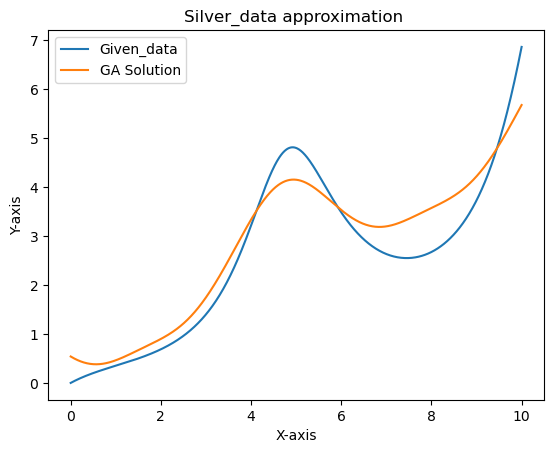

In [15]:
# %%
# testing  EP in this cell
#execution_time = timeit.timeit(lambda: Symbolic_Regession_EP(250, target_data=Bronze_data), number=1)
data = Silver_data
Bronze_population = Symbolic_Regession_EP(2000, target_data=data)
Bronze_population.run(min_fitness=.98)

best_ind = Bronze_population.fitness_ind[0]
best_func = Bronze_population.population[best_ind]

rslt_msg = ''
rslt_msg += f' Best function ' + best_func.build_function()
rslt_msg += f'  - FITNESS/MSE = {best_func.fitness(data)}'

print(rslt_msg)

best_func.plot_approximation(target_data=data, data_name='Silver_data')